# **Modelling and Evaluation**
---

## Objective

- Answer business requirement 2:
    * The client needs a tool that can tell their pets apart based on live image data.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 450x450) in each labelled folder, showing a close-up of the pet's face
- Image shape file

## Outputs

- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices
- Results of ML hyperparameter optimization
- Machine learning model creation and training
- Saved model
- Learning curve plot for model performance
- Model evaluation in pickle file
- Prediction on test data
- Prediction on live data

---

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil
import random

sns.set_style("white")


### Set the correct working directory

In [2]:
# Check the current working directory; os.chdir to change working directory if needed
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the paths to the input and output folders

In [4]:
# Save path names for each directory
full_dataset_path = os.path.normpath(os.path.join(cwd, 'inputs/datasets/pets'))

output_path = os.path.join(cwd, 'outputs')
train_path = os.path.join(full_dataset_path, 'train')
test_path = os.path.join(full_dataset_path, 'test')
validation_path = os.path.join(full_dataset_path, 'validation')


### Create style for highlighting errors and warnings

In [5]:
from colorama import Fore, Style

# Error notification style
def print_err(message):
    print(f'{Fore.RED}ERROR:{Style.RESET_ALL}\n{message}')

# Warning notification style
def print_warn(message):
    print(f'{Fore.YELLOW}WARNING:{Style.RESET_ALL}\n{message}')

--- 
## Data Balancing

In case the dataset is still unbalanced at this point and no more raw data can be collected and added, we can use other methods to balance the labels:
- Use class weights when fitting the model
- Undersample the labels with most data
- Oversample and augment the data

Let'S take a look at the current distribution numbers:

### Label distribution


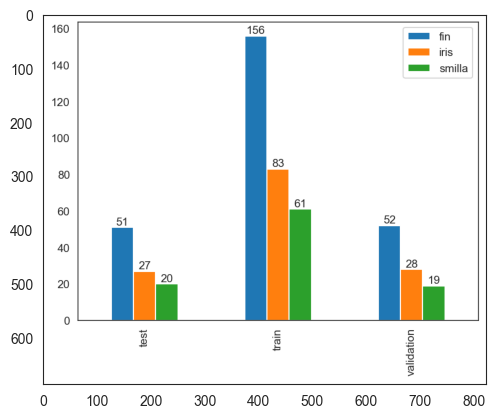

        test  train  validation
fin       51    156          52
iris      27     83          28
smilla    20     61          19


In [6]:
dataset_stats = joblib.load('outputs/labels_distribution.pkl')
plt.imshow(imread('outputs/labels_distribution.png'))
plt.show()
df = pd.DataFrame(dataset_stats)
print(df)

### Data balancing and augmentation

In this case, we decide to balance the data through augmentation and oversampling.

*Note:*
Should the application of class weights make more sense for a specific dataset, the following code can be run after the creation of the `y_train` variable and added to the `model.fit()` function as the `class_weight` parameter, to be used with a one-hot encoded list of labels:

```python
    from sklearn.utils import class_weight

    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(weights))
```


In [18]:
from sklearn.preprocessing import normalize

def get_augment_amounts(aug_percentage, stats):
    aug_stats = {}
    df = pd.DataFrame(stats)
    print('Current image distribution in the input dataset:\n')
    df.style.format_index(str.upper, axis=1)
    print(df)
    max_train_amount = df['train'].max()
    max_train_label = df['train'].idxmax()
    print(f'\nLabel with the most images: {max_train_label} - {max_train_amount} images\n')
    folders, ratios = joblib.load('outputs/split_ratio.pkl')
    ratios = normalize([list(ratios)], norm='max').reshape(-1)
    #print(ratios.reshape(-1))
    split_ratios = pd.Series(dict(zip(folders, ratios)))
    print(f'Normalized split ratios between the train, test, and validation subsets: {split_ratios}')
    max_augment = int(max_train_amount * (1 + aug_percentage))
    print(f'After the augmentation, each label in the training set will contain {max_augment} images.')
    # aug = pd.DataFrame(columns=folders, index=df.index)
    # print(aug)

    for col in split_ratios.keys():
        #print(col)
        aug_stats[col] = {}
        for idx in df[col].index:
            #print(idx, df[col][idx])
            aug_stats[col][idx] = int(max_augment * split_ratios[col] - df[col][idx])
            #aug[col][idx] = int(max_augment * split_ratios[col] - df[col][idx])
            #aug.loc[idx, col] = int(max_augment * split_ratios[col] - df[col][idx])
    #print(aug)
    
    return aug_stats

# By how many percent should the largest label be augmented?
aug_stats = get_augment_amounts(0.3, dataset_stats)
print('The following amounts of images need to be added to each label:')
print(pd.DataFrame(aug_stats))

Current image distribution in the input dataset:

        test  train  validation
fin       51    156          52
iris      27     83          28
smilla    20     61          19

Label with the most images: fin - 156 images

Normalized split ratios between the train, test, and validation subsets: train         1.000000
test          0.333333
validation    0.333333
dtype: float64
After the augmentation, each label in the training set will contain 202 images.
The following amounts of images need to be added to each label:
        train  test  validation
fin        46    16          15
iris      119    40          39
smilla    141    47          48


### Load and augment data

In [112]:
# Load all images from specified folder, resize them, save them as np array in X and save their labels in y
from imblearn.over_sampling import SMOTENC
from collections import Counter
from tensorflow.keras.layers import RandomRotation, RandomBrightness
import tensorflow as tf
tf.config.run_functions_eagerly(True)

def save_images_in_array(path, subset, aug_stats, size=(200, 200)):
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    new_shape = (-1, size[0], size[1], 3)
    # if has_label:
    for label in os.listdir(path):
        print(label)
        img_list = os.listdir(os.path.join(path, label))
        for img_name in img_list:
            img = image.load_img(os.path.join(path, label, img_name))
            img_resized = image.img_to_array(img.resize(size, resample=Image.LANCZOS))
            if img_resized.max() > 1:
                img_resized = img_resized / 255
            #print(img_resized)
            #X = np.append(X, img_resized)
            #print(X)
            X = np.append(X, img_resized)
            y = np.append(y, label)
            
        # Augment images manually:
        extra_amount = aug_stats[subset][label]
        extra_list = np.random.choice(img_list, size=extra_amount, replace=True)
        brightness = RandomBrightness([-0.15,0.15])
        rotation = RandomRotation([-0.1, 0.1])
        
        for img_name in extra_list:
            img = image.load_img(os.path.join(path, label, img_name))
            crop_p = random.randint(5, 30)
            img = img.crop((crop_p, crop_p, img.size[0]-crop_p, img.size[1]-crop_p))
            img_new = img.resize(size, resample=Image.LANCZOS)
            img_resized = image.img_to_array(img_new)
            img_resized = rotation(brightness(img_resized)).numpy() # image.random_brightness(img_resized, (-0.15, 0.15), scale=True)
            #img_aug = image.random_rotation(img_aug, )
            
            if img_resized.max() > 1:
                img_resized = img_resized / 255
            #print(img_resized)
            X = np.append(X, img_resized)
            y = np.append(y, label)
        
    X = X.reshape(new_shape)
    
    # SMOTENC oversampling not useable: too many errors in the resulting images
    
    # print(X.shape)
    # X_train = X.reshape(X.shape[0], np.prod(X.shape[1:]))
    # print(X_train.shape)
    # folders, ratios = joblib.load('outputs/split_ratio.pkl')
    # sm = SMOTENC(categorical_features=[0, 1, 2], sampling_strategy='not majority', random_state=42)
    # X_smote, y_smote = sm.fit_resample(X_train, y)
    # X_imgs = X_smote.reshape(new_shape)
    # print(sorted(Counter(y_smote).items()))
    
            
    # Shuffle the training set
    train_set = list(zip(y, X))
    random.shuffle(train_set)
    y_shuffled, X_shuffled = list(map(list, zip(*train_set)))
    X = np.array(X_shuffled, dtype='float')
    y = np.array(y_shuffled, dtype='object')
    
    return X, y


In [113]:
X_train_smote, y_train_smote = save_images_in_array(train_path, 'train', aug_stats, size=(200, 200))

fin
iris
smilla


(606, 200, 200, 3)
fin


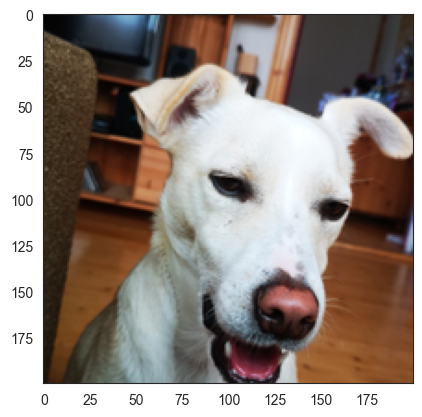

fin


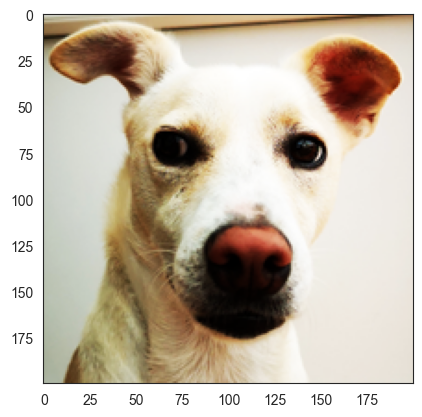

smilla


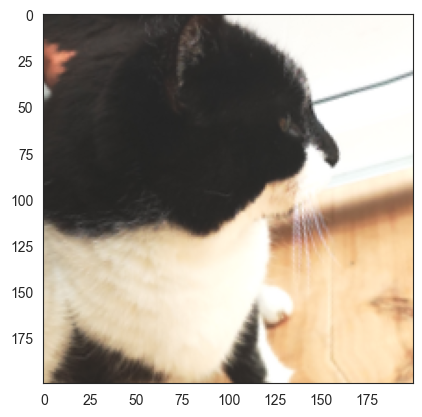

iris


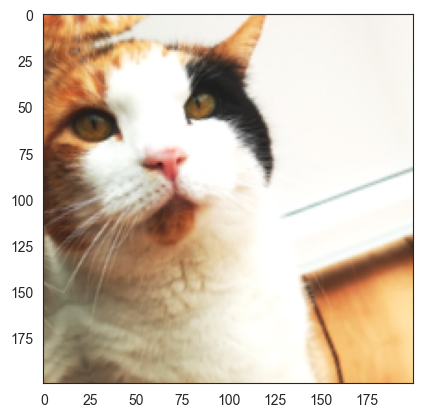

iris


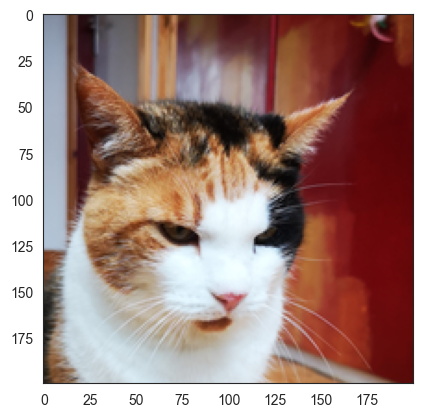

smilla


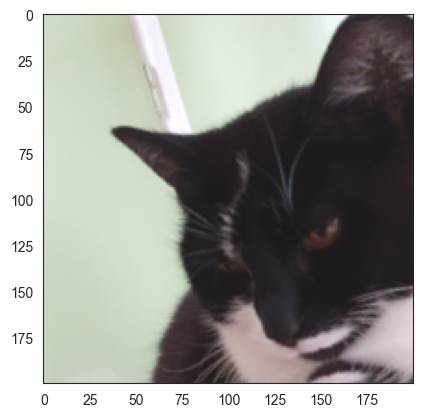

smilla


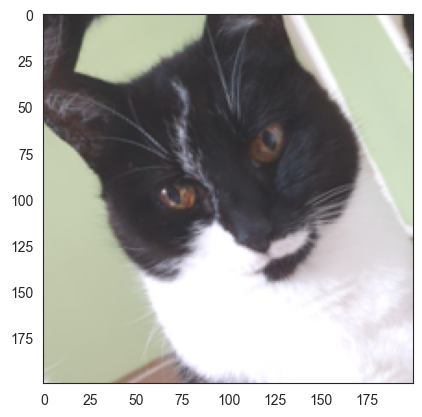

iris


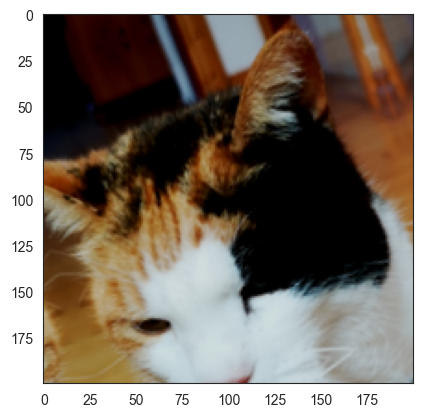

iris


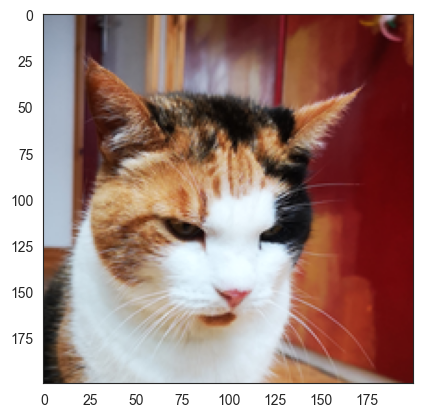

fin


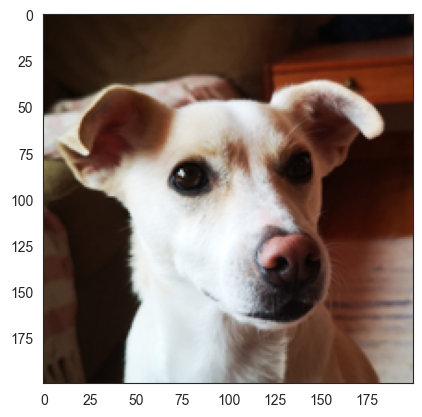

In [117]:
print(X_train_smote.shape)

for i in random.sample(range(0, X_train_smote.shape[0]), k=10):
    print(y_train_smote[i])
    plt.imshow(X_train_smote[i])
    plt.show()

### Compare averages

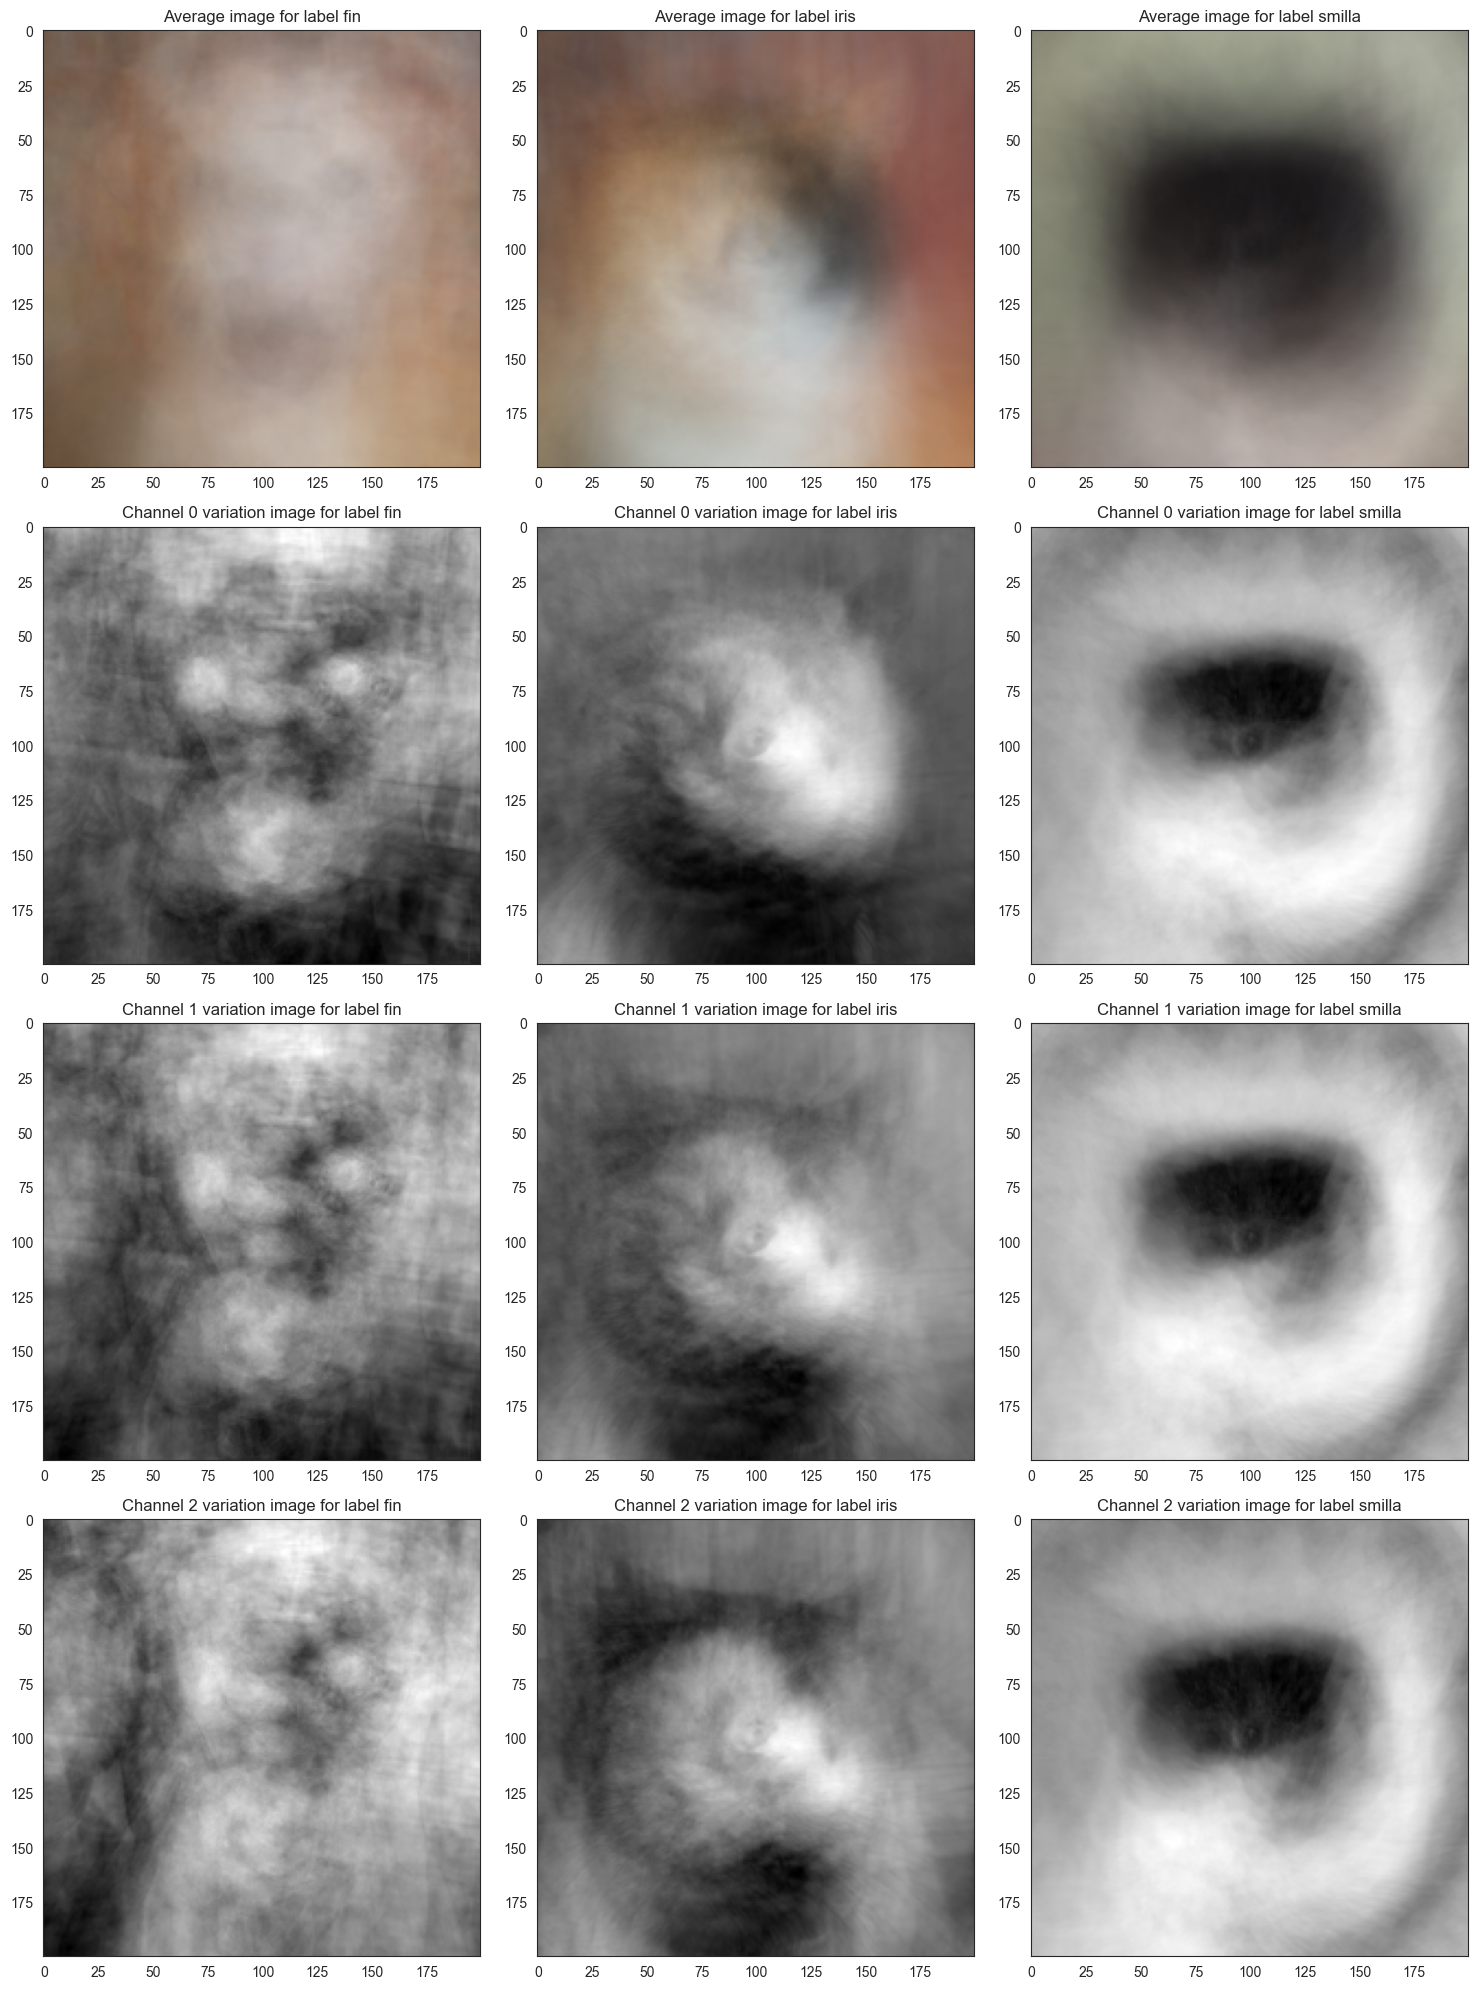

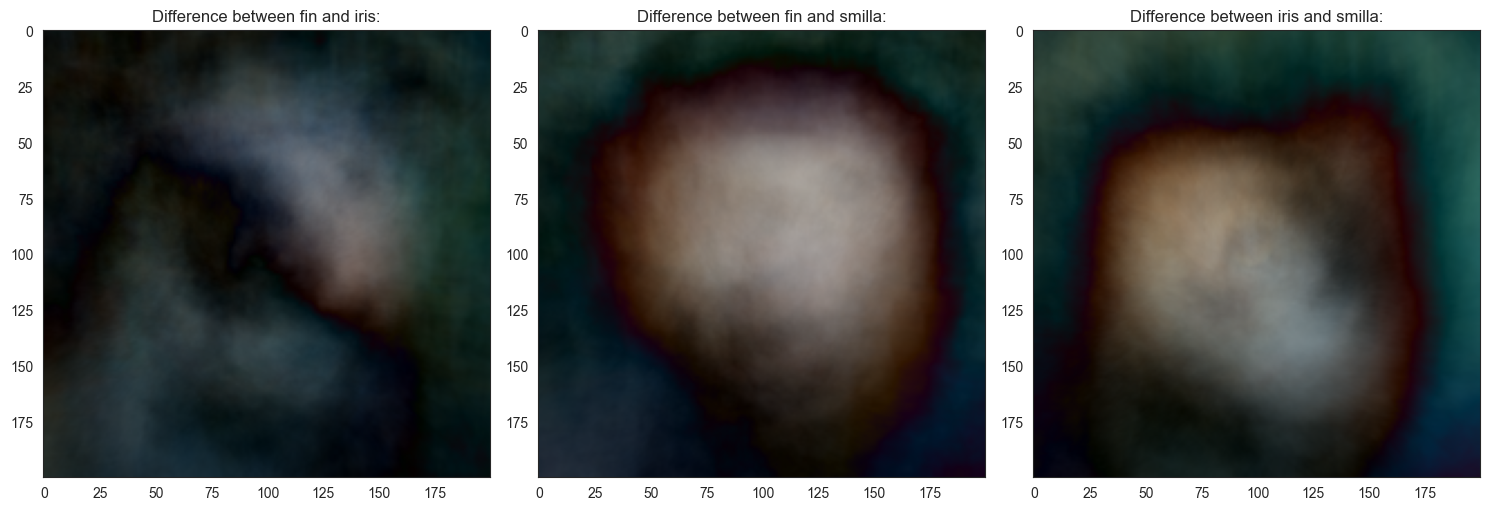

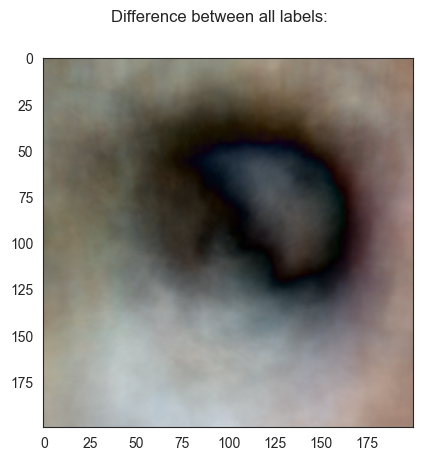

In [118]:

import itertools
import functools
# import math

def show_averages(X, y):
    
    label_imgs = {'Means': {}, 'Vars': {}}
    labels = np.unique(y)
    
    for label in labels:

        y = y.reshape(-1, 1, 1)
        bool_mask = np.any(y == label, axis=1).reshape(-1)
        arr = X[bool_mask]

        X_mean = np.mean(arr, axis=0)
        label_imgs['Means'][label] = X_mean
        #print(X_mean)
        # plt.imshow(X_mean)
        # plt.show()
        label_imgs['Vars'][label] = {}
        for channel in [0, 1, 2]:
            X_dev = np.std(arr[..., channel], axis=0)
            label_imgs['Vars'][label][channel] = X_dev

    means = label_imgs['Means']
    vars = label_imgs['Vars']
    fig, axes = plt.subplots(nrows=4, ncols=len(labels), figsize=(len(labels)*5, 20))
    for idx, label in enumerate(labels):
        axes[0][idx].set_title(f"Average image for label {label}")
        axes[0][idx].imshow(means[label], cmap='gray')

    for ch in [0, 1, 2]:
        for idx, label in enumerate(labels):
            axes[ch+1][idx].set_title(f"Channel {ch} variation image for label {label}")
            axes[ch+1][idx].imshow(vars[label][ch], cmap='gray')
    
    # TODO: save figure
    plt.tight_layout()
    plt.show()

    # len(labels) should be the amount of combos
    combos_len = sum(1 for _ in itertools.combinations(labels, 2))
    nrows = max(1, combos_len // 3)
    ncols = combos_len + (combos_len % 3)
    x_size = ncols * 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(x_size, nrows*5))
    for idx, combo in enumerate(itertools.combinations(labels, 2)):
        # mc = (means[combo[0]] - means[combo[1]]).reshape(-1)
        # mc = np.array([c if c > 0 else 0 for c in mc]).astype('float').reshape(200, 200, 3)
        #print(mc)
        mc = abs(means[combo[0]] - means[combo[1]])
        axes[idx].set_title(f"Difference between {combo[0]} and {combo[1]}:")
        axes[idx].imshow(mc, cmap='gray')
        
        #print(f'Difference between {combo[0]} and {combo[1]}:')
        #plt.imshow(mc)
    plt.tight_layout()
    plt.show()

    if len(labels) > 2:
        diffs = abs(functools.reduce(lambda a, b: a - b, means.values()))
        plt.suptitle(f'Difference between all labels:')
        plt.imshow(diffs)
        plt.show()

show_averages(X_train_smote, y_train_smote)
# show_averages(X_train, y_train, 'iris')
# show_averages(X_train, y_train, 'smilla')


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
# axes[0].set_title(f"Average image for label {label_to_display}")
# axes[0].imshow(avg_img, cmap='gray')


### Load the other subsets and one-hot encode all label lists

### Build a model and find the best parameters

### Train and fit the model

## Evaluate